# Summarize population density maps (`.tif`) by shapefiles (`.shp`)

### What does this do

This notebook allows you to:
1. Load a `.tif` population density file and a `.shp` shapefile

2. Sum the values of the pixels in the density map inside each given shape, resulting in a table of shape attributes (e.g. admin level names) and the respective population

3. Save the resulting table in a `.csv` file

### How to run
1. Install Python and Jupyter (recommended distribution: the latest `miniconda`)

2. Use `pip` to install the following packages if not already installed:
    - `rasterstats`
    
    - `rioxarray`

    - `pandas`

    - `geopandas`
    
    - `matplotlib`


3. Download your chosen population density map and shapefile and set the data paths here correctly

4. Run the `Setup` and `Functions` section and the relevant country and/or copy a country example cell and modify it to match your density map and shapefile.

# Setup

In [1]:
from pathlib import Path
import os

import rioxarray as rxr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
from rasterstats import zonal_stats

## NECESSARY FUNCTION TO EXTEND `zonal_stats` TO WORK WITH XARRAYS
def zonal_stats_extended(gdf, xds, prefix=None, stats="sum", output_type="dataframe"):
    """
    Extends rasterstarts' zonal_stats to easily input xarrays and output a Pandas DataFrame.

    Default operation is "sum".

    """
    raster = xds.to_numpy()[0]
    affine = xds.rio.transform()
    nodata_value = xds.rio.nodata

    zs = zonal_stats(
        gdf,
        raster,
        affine=affine,
        nodata=nodata_value,
        stats=stats,
        prefix=prefix,
    )

    if output_type == "dataframe":
        return pd.DataFrame(zs, index=gdf.index)
    else:
        return zs

In [3]:
# Set paths to data folders
path = Path.cwd()
data_path = path / "Data"
output_path = path / "Output_Data"

# Full run

## Functions

In [4]:
def load_tif(path):
    """load raster population density data (.tif) with np.nan as nodata value"""

    return rxr.open_rasterio(path, masked=True)

In [5]:

def load_and_sum_tif(tif_file_path, gdf, prefix=None, rounding=True):
    """Load a pop density map from file and create zonal sums using shapes from the given gdf."""

    xds = load_tif(tif_file_path)

    zonal_stats_df = zonal_stats_extended(
        gdf=gdf,
        xds=xds,
        prefix=prefix,
        stats="sum"
    )

    if rounding:
        zonal_stats_df = zonal_stats_df.round().fillna(0).astype(int)

    return zonal_stats_df

In [6]:
def load_and_sum_multiple_tifs(
    gdf,
    tif_folder_path=None,
    tif_file_paths=None,
    global_prefix=None, 
    file_prefix_list=None,
    rounding=True, 
    total_column=True
    ):
    """

    Primarily for WorldPop data since multiple files are provided, each for a different age/gender group.
    
    Load each density map file (either from a given folder or a list of file paths) and 
    get zonal sums of each based on a GeoDataFrame of shapes. Combine the results into 
    a single pandas dataframe and add a totals column if required.
    
    Parameters
    ----------
    gdf : geopandas.GeoDataFrame
        GeoDataFrame with shapes to summarize over.
    tif_folder_path : pathlib.Path, optional
        Path to folder with tif files to load. If provided, all tif files in the folder will be loaded and the 
        tif_file_paths parameter will be ignored.
    tif_file_paths : list, required if tif_folder_path is None
        List of paths to tif files.
    global_prefix : str, optional
        Prefix to add to all column names, by default None
    file_prefix_list : list, optional
        List of prefixes to add to each column name, by default None. If provided, must be the same length as the
        tif_file_paths list. If not provided, the file name will be used as the prefix.
    sum_rounding : bool, optional
        Whether to round sum values, by default True
    total_column : bool, optional
        Add a column with the total sum of all columns, by default True
        
    Returns
    -------
    pd.DataFrame
    
    """

    if tif_folder_path:
        tif_file_paths = list(tif_folder_path.glob("*.tif"))

    if not file_prefix_list:
        file_prefix_list = [f.stem for f in tif_file_paths]

    zonal_stats_df_list = []

    for tif_file_path, file_prefix in zip(tif_file_paths, file_prefix_list):
        prefix = global_prefix+file_prefix+"_"
        zonal_stats_df = load_and_sum_tif(tif_file_path, gdf, prefix, rounding)
        zonal_stats_df_list.append(zonal_stats_df)

    zonal_stats_df_all = pd.concat(zonal_stats_df_list, axis=1)


    if total_column:
        zonal_stats_df_all[global_prefix+"sum_total"] = zonal_stats_df_all.sum(axis=1)

    return zonal_stats_df_all

In [7]:
def combine_dataframes(
    gdf, 
    df_list, 
    shape_cols_to_keep, 
    save_csv, 
    output_csv_name="zonal_sums.csv"
    ):
    """Combine a list of dataframes with zonal sums with a GeoDataFrame of shapes and save result to file."""
    
    # combine all population dataframes
    pops_df = pd.concat(df_list, axis=1)

    # Combine with shape data
    gdf = gdf[shape_cols_to_keep+["geometry"]]
    combined_pops_gdf = pd.concat([gdf, pops_df], axis=1)

    # sort by area names
    combined_pops_gdf.sort_values(by=shape_cols_to_keep, inplace=True)

    ## save
    if save_csv:
        # save
        os.makedirs(output_path, exist_ok=True)
        combined_pops_gdf.drop(columns="geometry", axis=1).to_csv(output_path / output_csv_name, index=False,encoding  =  "utf-8" )

    return combined_pops_gdf

In [8]:
def df_w_latlons_to_gdf(
    df,
    lat_name = "Lat",
    lon_name = "Lon",
    crs="EPSG:4326",
):
    """
    Convert DataFrame to GeoDataFrame by creating geometries from lat-lon columns.

    Parameters
    ----------
    df : The DataFrame to convert.
    lat_name, lon_name : The names of the columns containing the latitude and longitude values.
        Default is 'Lat' and 'Lon'.
    crs : The coordinate reference system of the lat-lon columns.
    """
    latlon_point_geoms = gpd.points_from_xy(x=df[lon_name], y=df[lat_name])
    gdf = gpd.GeoDataFrame(df.copy(), geometry=latlon_point_geoms, crs=crs)
    return gdf

## Country Specific WorldPop/FB/WOPR summaries
(Summarising multiple `.tif` density files and combining the results)

### Example: Nigeria

#### Loading the shape data

In [9]:
nigeria_adm2_gdf = gpd.read_file(data_path / "Administrative Boundaries" / "nga_adm_osgof_20190417_nigeria" / "nga_admbnda_adm2_osgof_20190417.shp")
nigeria_adm2_gdf.head()

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,SD_EN,SD_PCODE,geometry
0,0.237074,0.001524,Aba North,NG001001,Aba North,None,None,Abia,NG001,Nigeria,NG,2016-11-29,2019-04-17,None,Abia South,NG00103,"POLYGON ((7.40111 5.08195, 7.40013 5.08237, 7...."
1,0.262477,0.003531,Aba South,NG001002,Aba South,None,None,Abia,NG001,Nigeria,NG,2016-11-29,2019-04-17,None,Abia South,NG00103,"POLYGON ((7.38749 5.08275, 7.38632 5.08236, 7...."
2,3.075316,0.326868,Abadam,NG008001,Abadam,None,None,Borno,NG008,Nigeria,NG,2016-11-29,2019-04-17,None,Borno North,NG00802,"POLYGON ((13.83477 13.42336, 13.81909 13.42175..."
3,2.537984,0.068379,Abaji,NG015001,Abaji,None,None,Federal Capital Territory,NG015,Nigeria,NG,2016-11-29,2019-04-17,None,Federal Capital Territory,NG01501,"POLYGON ((7.04587 9.23050, 7.02654 9.22216, 7...."
4,0.687150,0.014529,Abak,NG003001,Abak,None,None,Akwa Ibom,NG003,Nigeria,NG,2016-11-29,2019-04-17,None,Akwa Ibom North West,NG00302,"POLYGON ((7.81124 5.09453, 7.81233 5.09367, 7...."


#### Subset the data to only include required states

In [10]:
nigeria_mc_states=["Bauchi", "Borno", "Kebbi", "Kogi", "Nasarawa", "Plateau", "Sokoto"]
nigeria_adm2_gdf_mc_chosen_adm1 = nigeria_adm2_gdf[nigeria_adm2_gdf["ADM1_EN"].isin(nigeria_mc_states)]

#### Load the population density files

In [11]:
worldpop_cons_folder_path= path / "Data" / "WorldPop_Constrained_1km_UNadj"/"Nigeria"
worldpop_wopr_file_path= path/"Data"/ "WorldPop_WOPR" / "Nigeria" /"Data"/ "NGA_population_v2_0_agesex_under5.tif"
facebook_file_path= path/"Data" / "Meta_HRSL" / "nga_children_under_five_2020_geotiff_Nigeria" / "nga_children_under_five_2020.tif"
facebook_csv_file_path= path/"Data" / "Meta_HRSL" / "nga_children_under_five_2020_geotiff_Nigeria" / "nga_children_under_five_2020.csv"

In [12]:
# WorldPop Top-down Constrained estimates
worldpop_cons_pops_df = load_and_sum_multiple_tifs(
    gdf=nigeria_adm2_gdf_mc_chosen_adm1,
    tif_folder_path=worldpop_cons_folder_path,
    global_prefix="worldpop_cons_u5_", 
    rounding=True, 
    total_column=True
    )

worldpop_cons_pops_df

,worldpop_cons_u5_nga_f_0_4_2021_1km_UNadj_constrained_Nigeria_sum,worldpop_cons_u5_nga_m_0_4_2021_1km_UNadj_constrained_Nigeria_sum,worldpop_cons_u5_sum_total
2,12219,11903,24122
12,21224,20675,41899
30,17818,17356,35174
45,13897,13537,27434
47,5185,5051,10236
...,...,...,...
754,15498,15097,30595
755,17285,16838,34123
760,6454,6287,12741
767,29806,29034,58840


In [13]:
# WorldPop Bottom-up estimates
worldpop_wopr_pops_df = load_and_sum_tif(
    worldpop_wopr_file_path,
    nigeria_adm2_gdf_mc_chosen_adm1,
    prefix="worldpop_wopr_u5_",
    rounding=True
)


worldpop_wopr_pops_df

,worldpop_wopr_u5_sum
2,20733
12,35143
30,20269
45,38298
47,17529
...,...
754,17070
755,10122
760,36091
767,54292


In [14]:
# Facebook
facebook_pops_df = load_and_sum_tif(
    facebook_file_path,
    nigeria_adm2_gdf_mc_chosen_adm1,
    prefix="facebook_u5_",
    rounding=True
)
facebook_pops_df

,facebook_u5_sum
2,27300
12,48042
30,36646
45,27903
47,11601
...,...
754,35183
755,35326
760,13692
767,64291


In [15]:
# If facebook .tif files don't work, you can use the csv files

# facebook_csv_df = pd.read_csv(facebook_csv_file_path)
# facebook_csv_gdf = df_w_latlons_to_gdf(facebook_csv_df, lat_name = "latitude", lon_name = "longitude")  
# facebook_csv_gdf_w_adm = facebook_csv_gdf.sjoin(nigeria_adm2_gdf_mc_chosen_adm1)
# facebook_pops_df = facebook_csv_gdf_w_adm.pivot_table(values="nga_children_under_five_2020", index=["ADM1_EN","ADM2_EN"], aggfunc=np.sum).reset_index()
# pivot_pop_df

##### Discounting for months not covered assuming growth is linear


In [16]:
worldpop_cons_pops_df["worldpop_cons_3-59_months"] = worldpop_cons_pops_df["worldpop_cons_u5_sum_total"] * (57/60)
worldpop_wopr_pops_df["worldpop_wopr_3-59_months"] = worldpop_wopr_pops_df["worldpop_wopr_u5_sum"] * (57/60)
facebook_pops_df["facebook_3-59_months"] = facebook_pops_df["facebook_u5_sum"] * (57/60)

In [17]:
df_list = [worldpop_cons_pops_df, worldpop_wopr_pops_df,facebook_pops_df]


combined_pops_gdf = combine_dataframes(
    nigeria_adm2_gdf_mc_chosen_adm1, 
    df_list, 
    shape_cols_to_keep=["ADM1_EN","ADM2_EN"], 
    save_csv=True, 
    output_csv_name="mc_nigeria_output.csv"
    )

<Axes: >

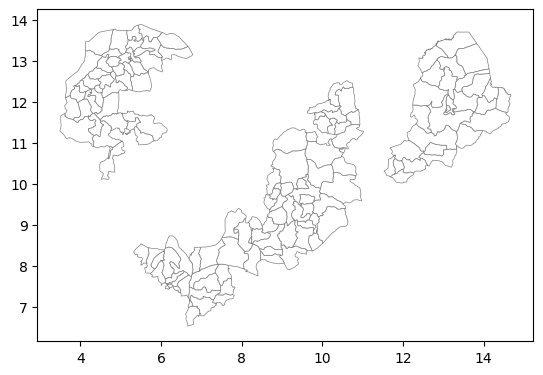

In [18]:
combined_pops_gdf.plot(color="white", edgecolor="gray", linewidth=0.5)